In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
from deepmeg.models.interpretable import SPIRIT, LFCNN, TimeCompNet
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
import matplotlib.pyplot as plt
import numpy as np

In [68]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [69]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)

# for c in cond:
#     c['tmin'] = -.5
#     c['tmax'] = 1.

# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs_original = epochs.copy()


In [71]:
epochs = epochs_original.copy()
epochs.apply_baseline((None, 0.))
epochs.crop(.0, None)
dataset = EpochsDataset(
    epochs,
    savepath='../datasets/multimodal',
    transform=zscore
)
train, test = torch.utils.data.random_split(dataset, [.7, .3])

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


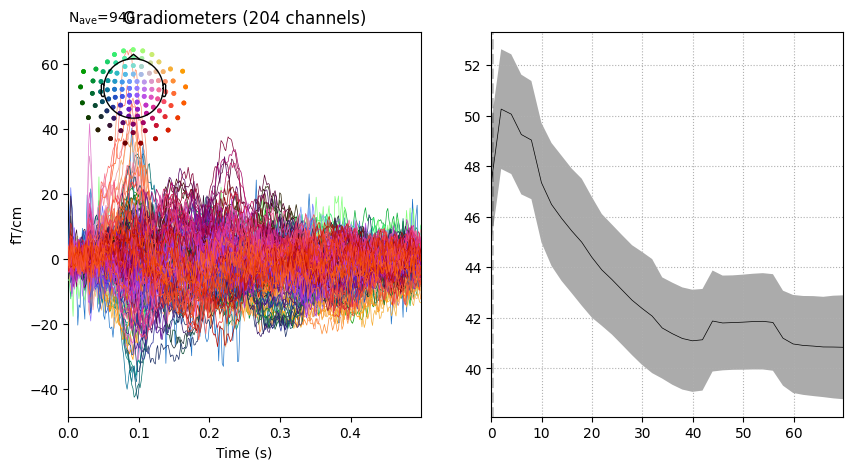

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
epochs.plot_psd(average=True, ax=ax2, fmax=70)
epochs.average().plot(axes=ax1)
plt.show()

In [73]:
dataset.save('../data/multimodal.pt')

In [53]:
X.shape[-1]

782

In [74]:

X, y = next(iter(DataLoader(test)))

model_kwargs = dict(
    n_channels=204,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    pool_factor=10,
    n_outputs=8
)

LFCNN(
    **model_kwargs
)(X)

tensor([[-0.2159, -0.0069,  0.1124, -0.1126, -0.0845, -0.0943, -0.0112,  0.1640]],
       grad_fn=<AddmmBackward0>)

In [75]:
# from deepmeg.models.interpretable import LFCNN

model = LFCNN(
    **model_kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7195   |    binary_accuracy_train:  0.5406   |    loss_val:  0.7070   |    binary_accuracy_val:  0.5948
Epoch 1:  loss_train:  0.6935   |    binary_accuracy_train:  0.6549   |    loss_val:  0.6843   |    binary_accuracy_val:  0.6882
Epoch 2:  loss_train:  0.6670   |    binary_accuracy_train:  0.7430   |    loss_val:  0.6595   |    binary_accuracy_val:  0.7541
Epoch 3:  loss_train:  0.6381   |    binary_accuracy_train:  0.7839   |    loss_val:  0.6320   |    binary_accuracy_val:  0.7858
Epoch 4:  loss_train:  0.6058   |    binary_accuracy_train:  0.8132   |    loss_val:  0.6016   |    binary_accuracy_val:  0.8057
Epoch 5:  loss_train:  0.5704   |    binary_accuracy_train:  0.8287   |    loss_val:  0.5699   |    binary_accuracy_val:  0.8208
Epoch 6:  loss_train:  0.5335   |    binary_accuracy_train:  0.8353   |    loss_val:  0.5398   |    binary_accuracy_val:  0.8167
Epoch 7:  loss_train:  0.4982   |    binary_accuracy_train:  0.8392   |    loss_val:  0.5143   | 

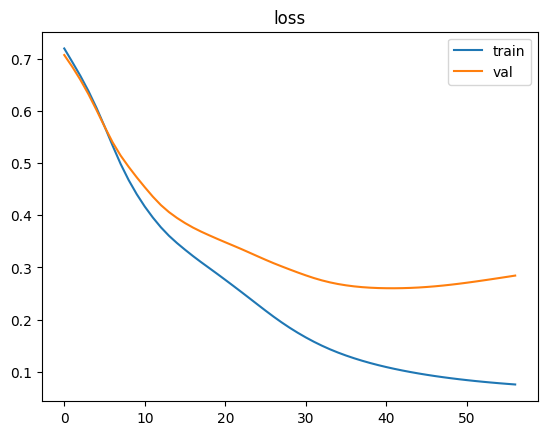

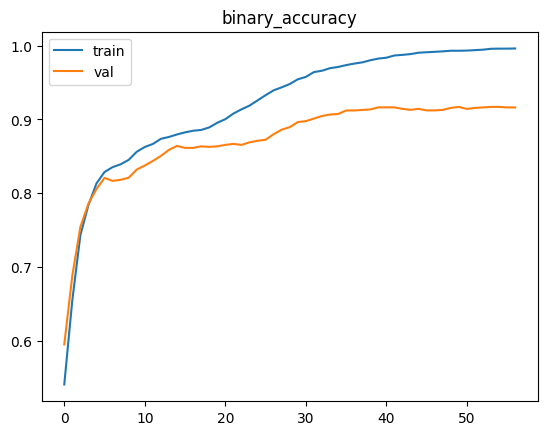

In [76]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [77]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1422000595114448
train_binary_accuracy: 0.9704108346592296
loss: 0.22342690283601935
binary_accuracy: 0.9374999945813959


In [78]:
info = epochs.info

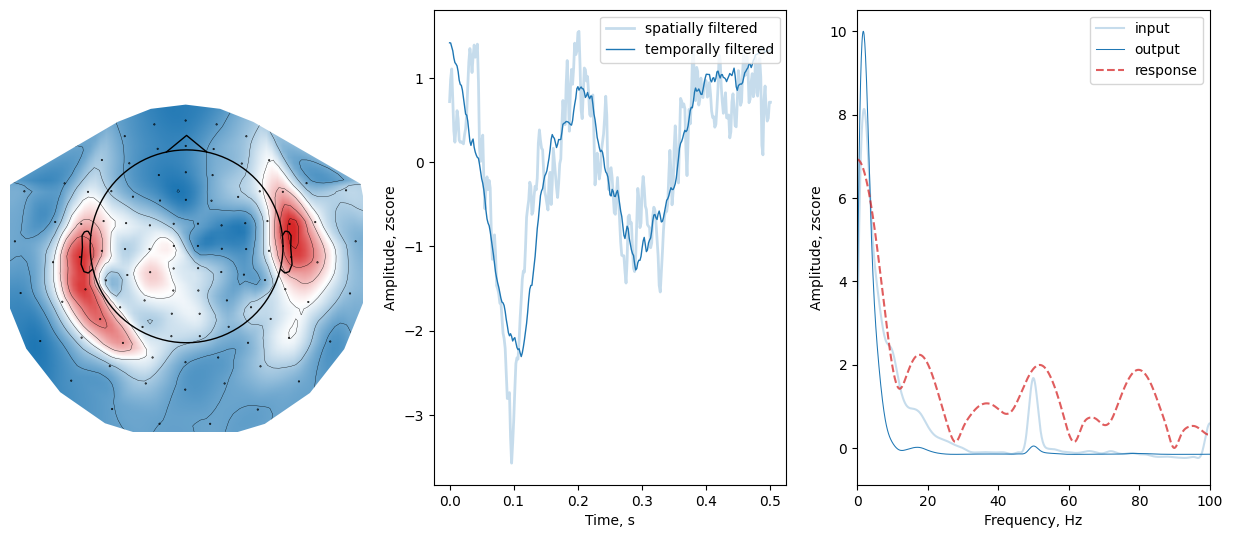

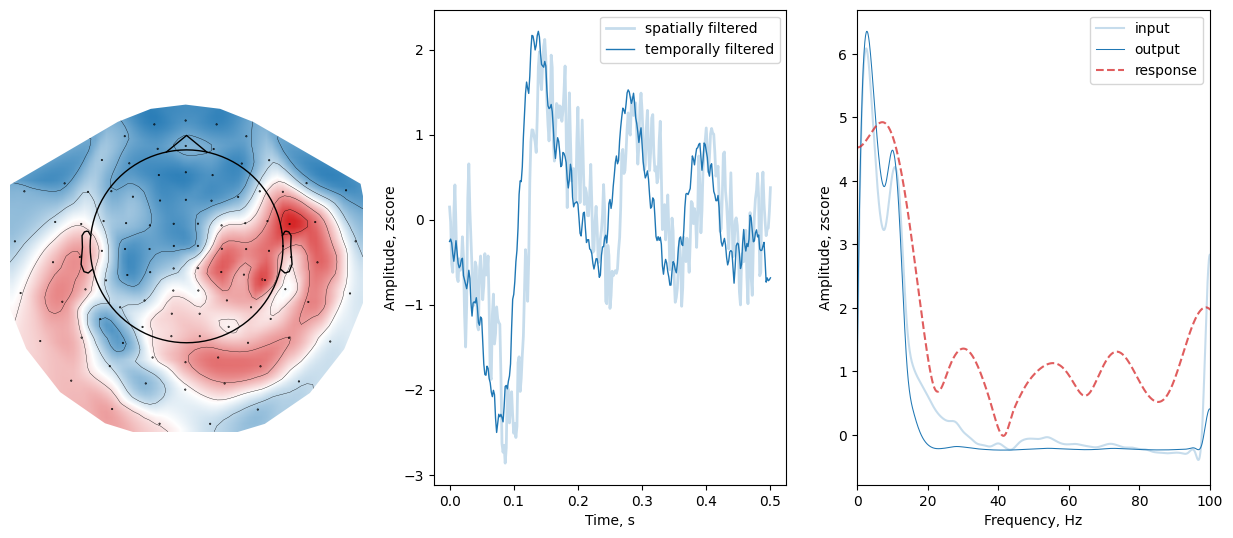

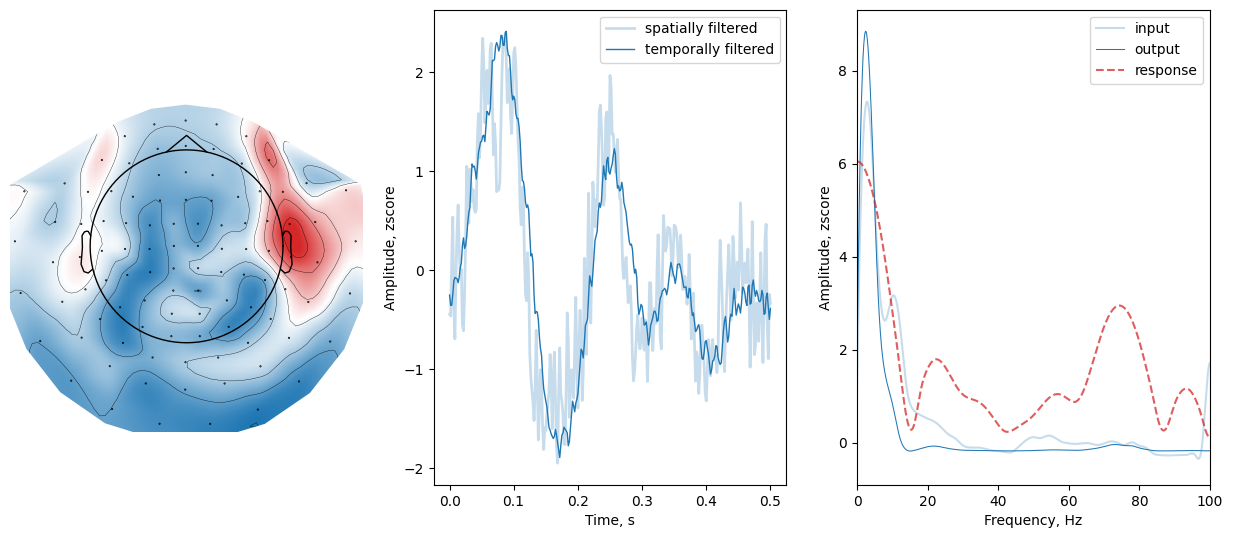

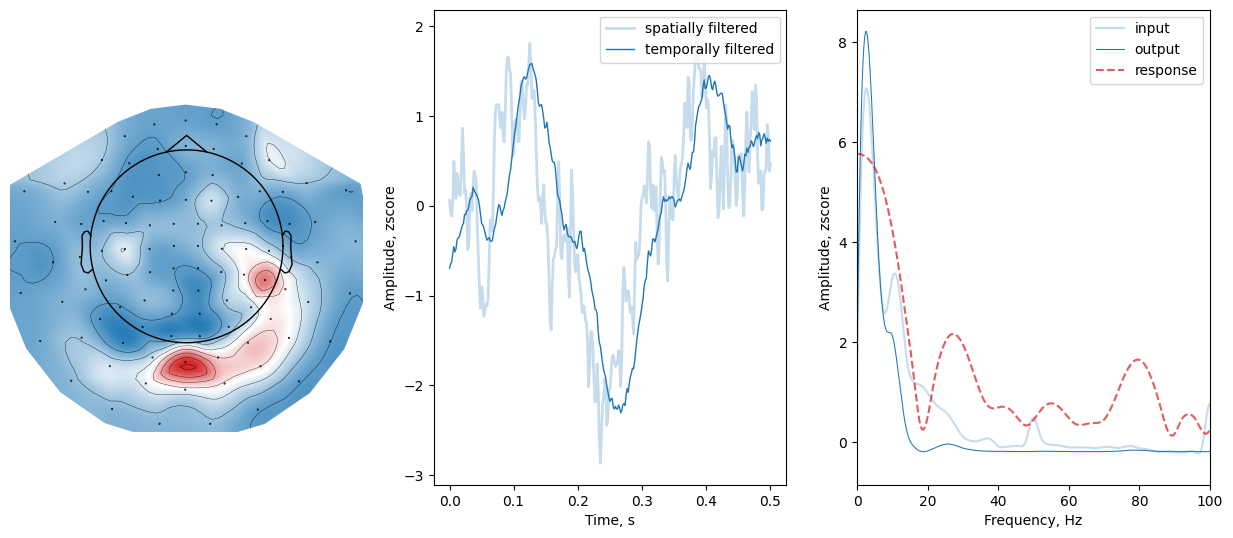

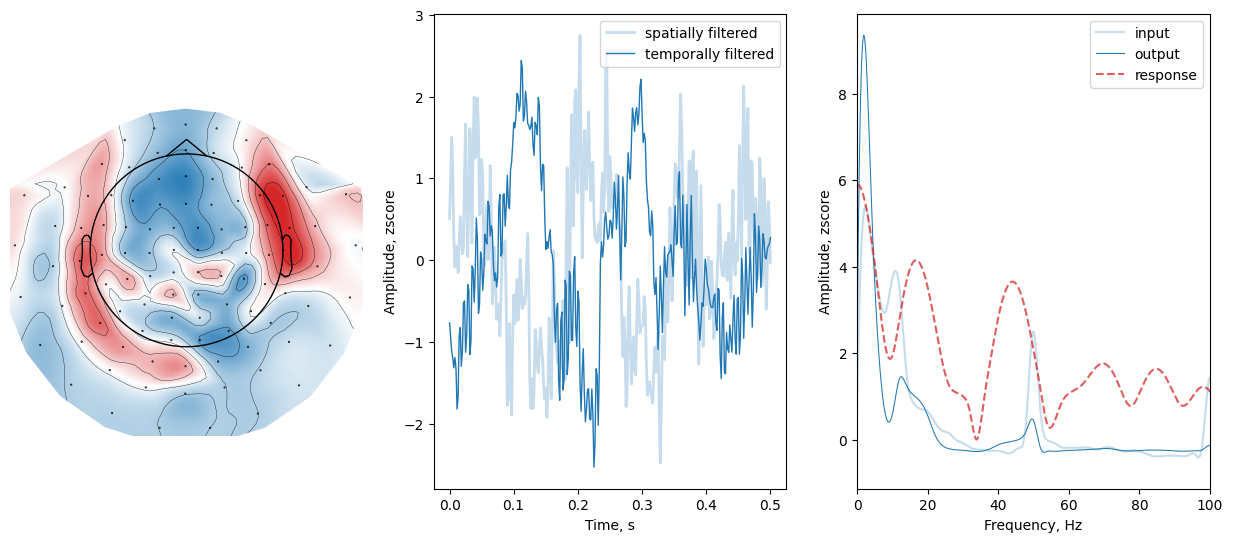

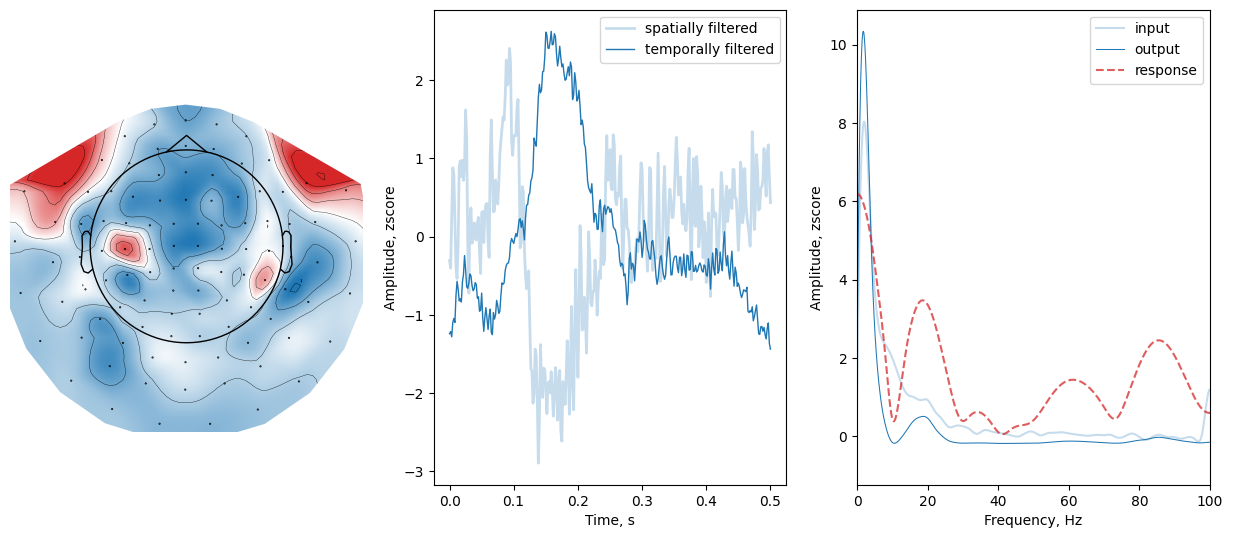

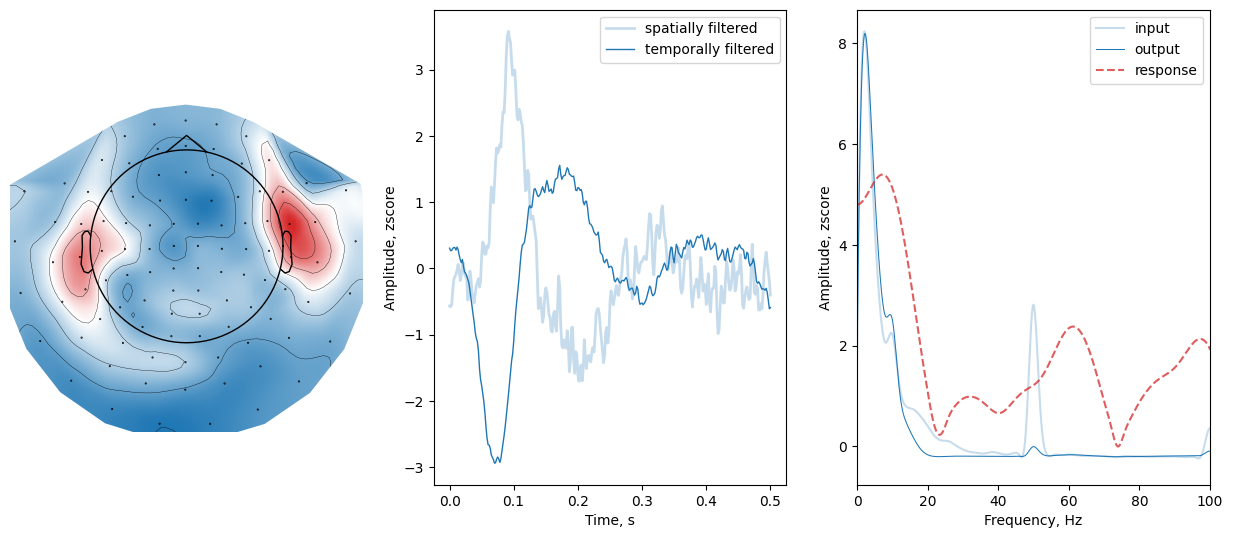

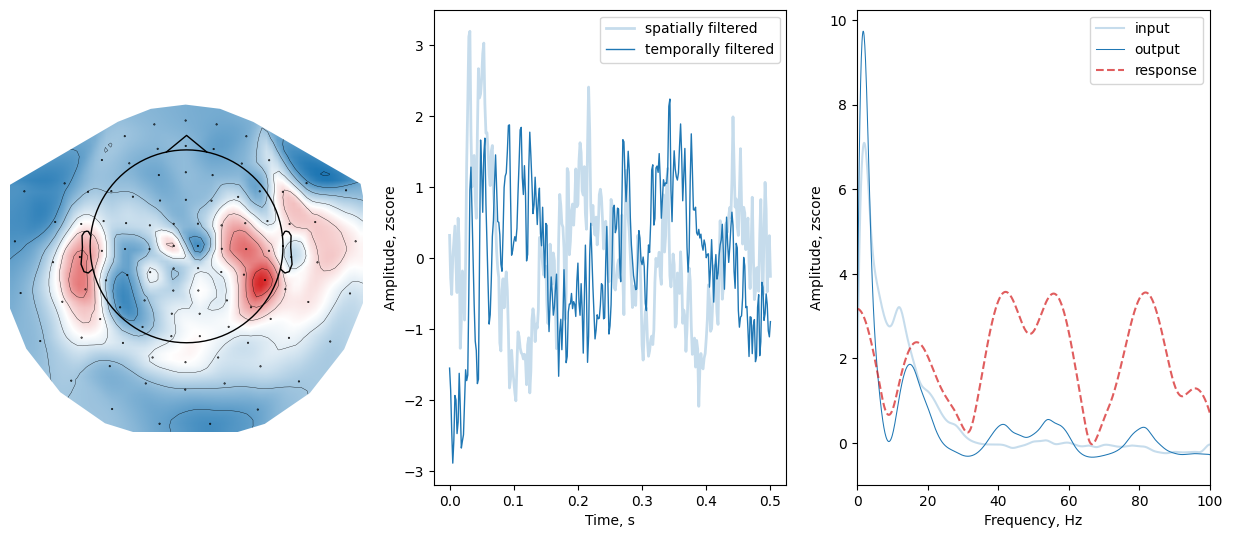

In [79]:
from deepmeg.interpreters import LFCNNInterpreter

interpreter = LFCNNInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [80]:
model_kwargs = dict(
    n_channels=204,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    window_size=10,
    latent_dim=10,
    pool_factor=10,
    n_outputs=8
)

In [81]:
SPIRIT(
    **model_kwargs
)(X)

tensor([[ 0.1649,  0.1436, -0.1774,  0.2891, -0.2222, -0.4453,  0.3701,  0.0876]],
       grad_fn=<AddmmBackward0>)

In [82]:
model = SPIRIT(
    **model_kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                *[f'timesel_list.{i}.0.weight' for i in range(8)],
                *[f'timecomp_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[
                .01, .01,
                *[.01 for _ in range(8)],
                *[.01 for _ in range(8)]
            ]
            # lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  1.1650   |    binary_accuracy_train:  0.4309   |    loss_val:  1.0719   |    binary_accuracy_val:  0.6002
Epoch 1:  loss_train:  1.0391   |    binary_accuracy_train:  0.7390   |    loss_val:  0.9695   |    binary_accuracy_val:  0.8750
Epoch 2:  loss_train:  0.9475   |    binary_accuracy_train:  0.8750   |    loss_val:  0.8994   |    binary_accuracy_val:  0.8750
Epoch 3:  loss_train:  0.8868   |    binary_accuracy_train:  0.8750   |    loss_val:  0.8565   |    binary_accuracy_val:  0.8750
Epoch 4:  loss_train:  0.8511   |    binary_accuracy_train:  0.8750   |    loss_val:  0.8347   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.8339   |    binary_accuracy_train:  0.8750   |    loss_val:  0.8276   |    binary_accuracy_val:  0.8750
Epoch 6:  loss_train:  0.8286   |    binary_accuracy_train:  0.8750   |    loss_val:  0.8272   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.8271   |    binary_accuracy_train:  0.8750   |    loss_val:  0.8276   | 

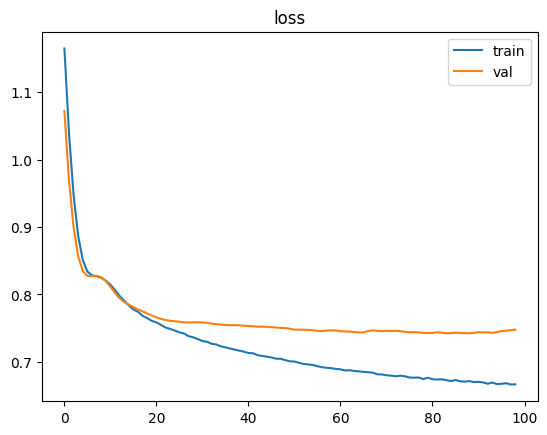

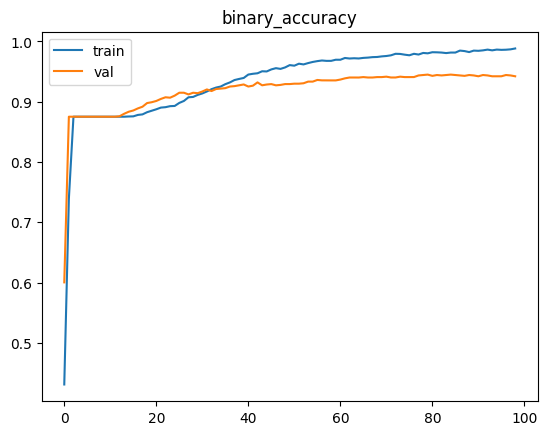

In [83]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [84]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.6744146130301736
train_binary_accuracy: 0.9807473746213046
loss: 0.7682729471813549
binary_accuracy: 0.9301948005502875


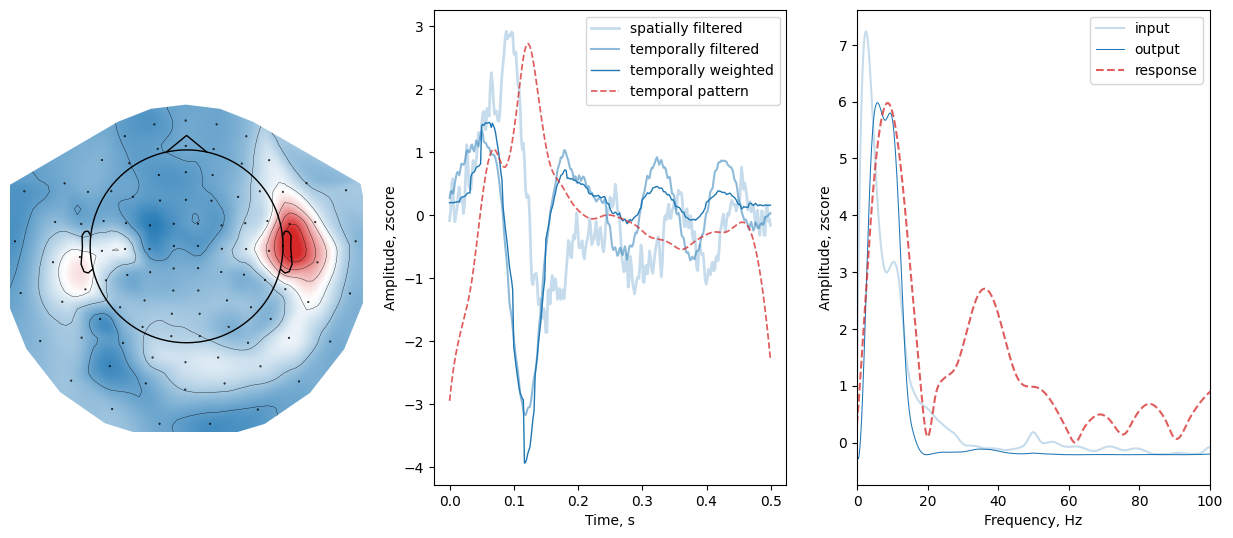

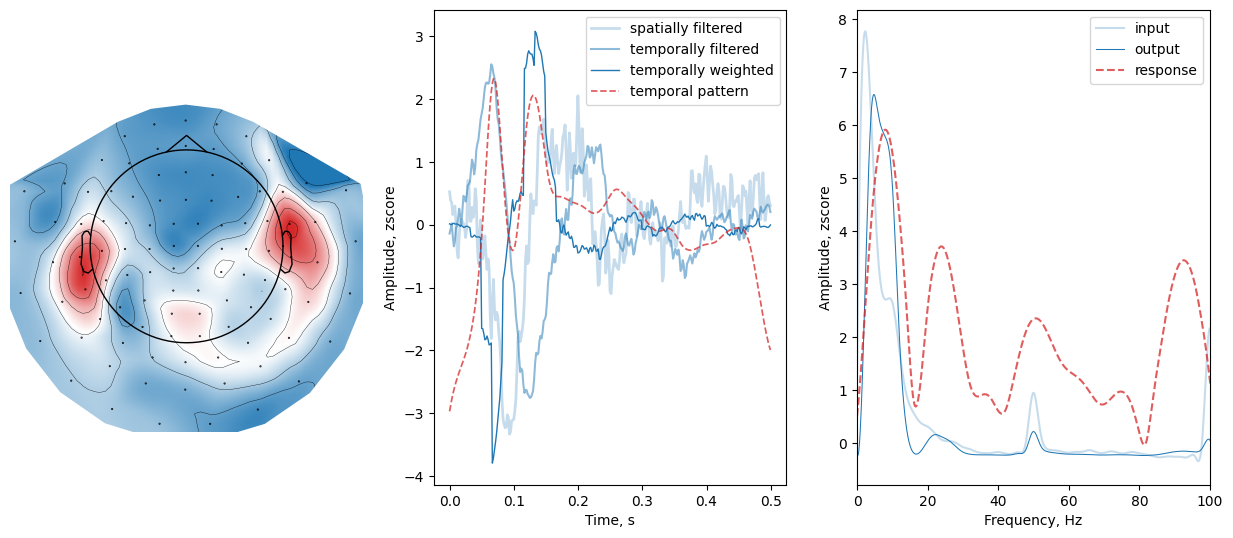

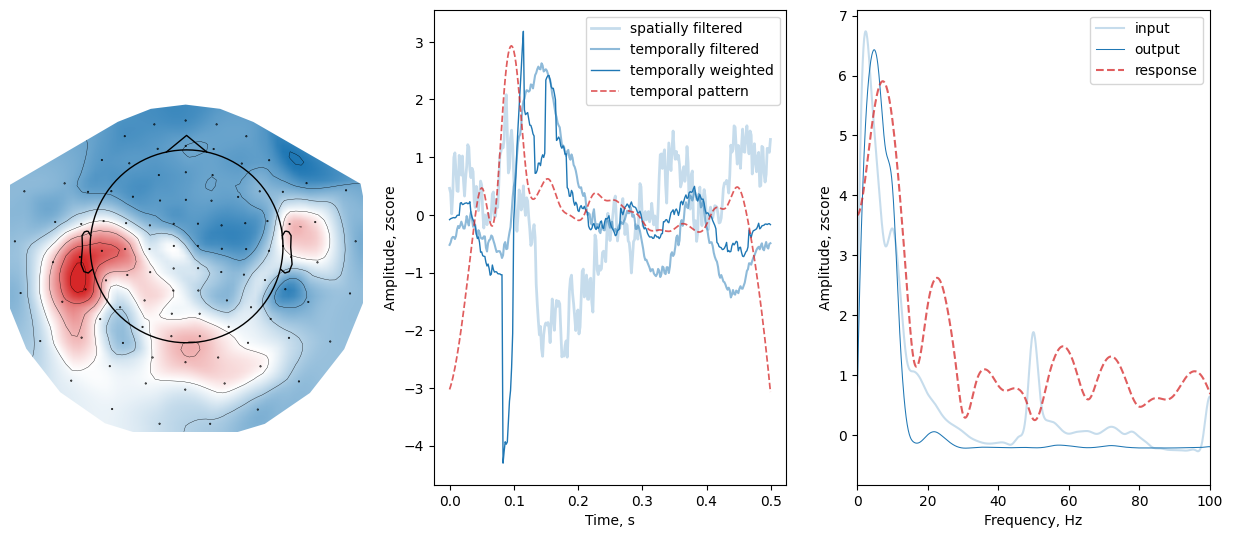

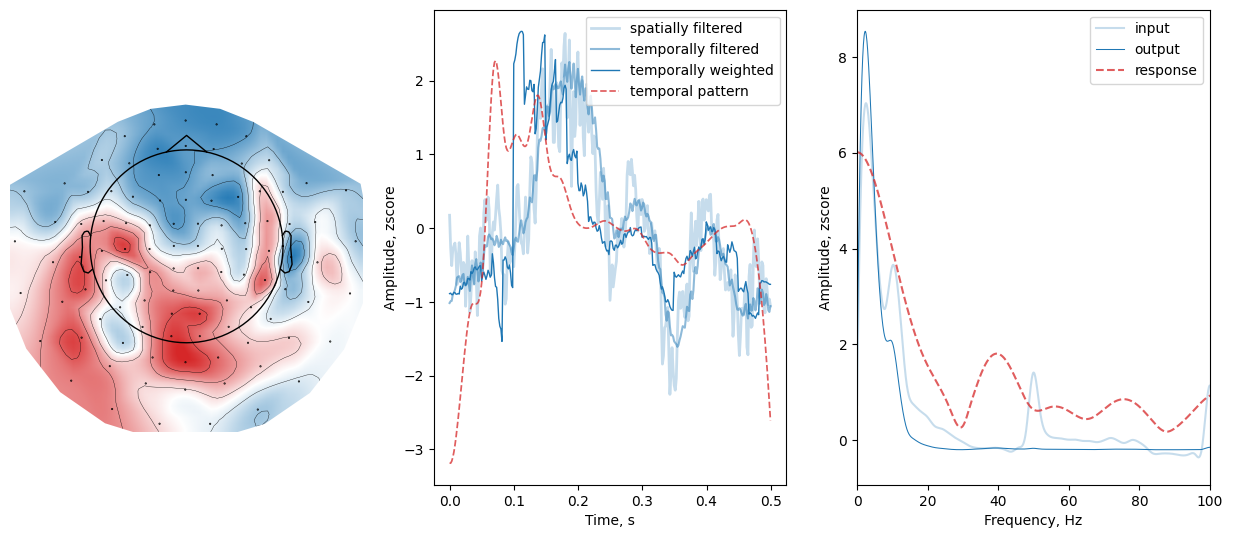

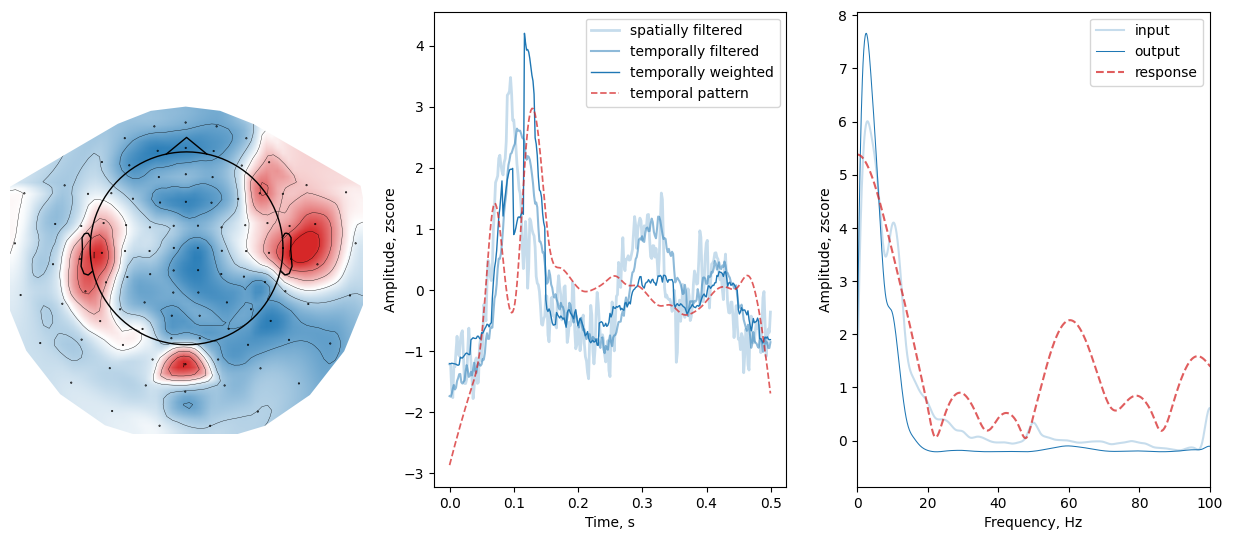

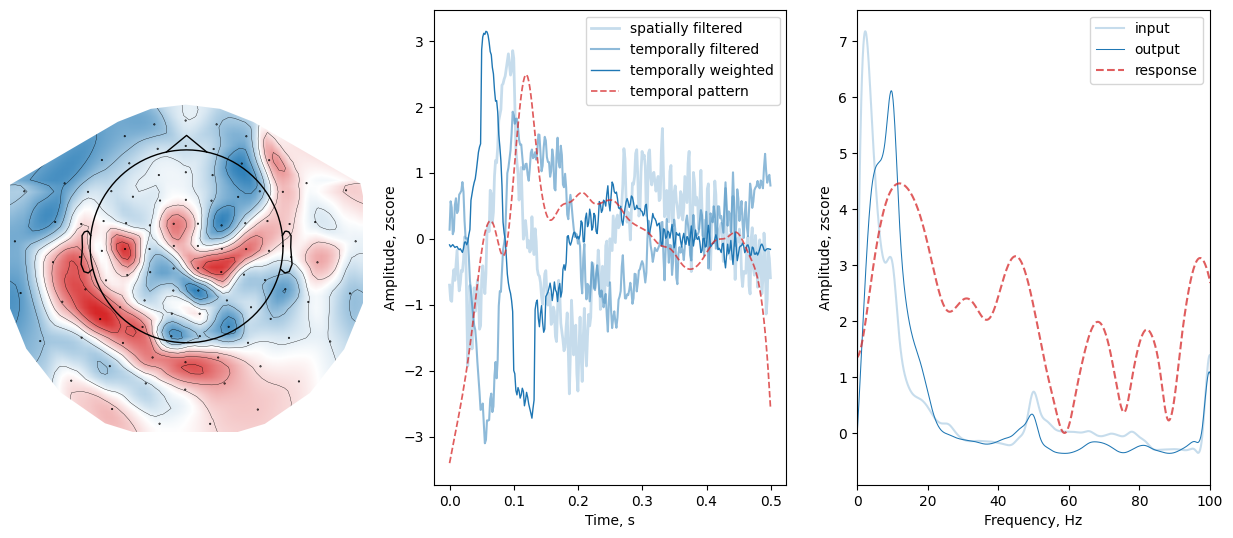

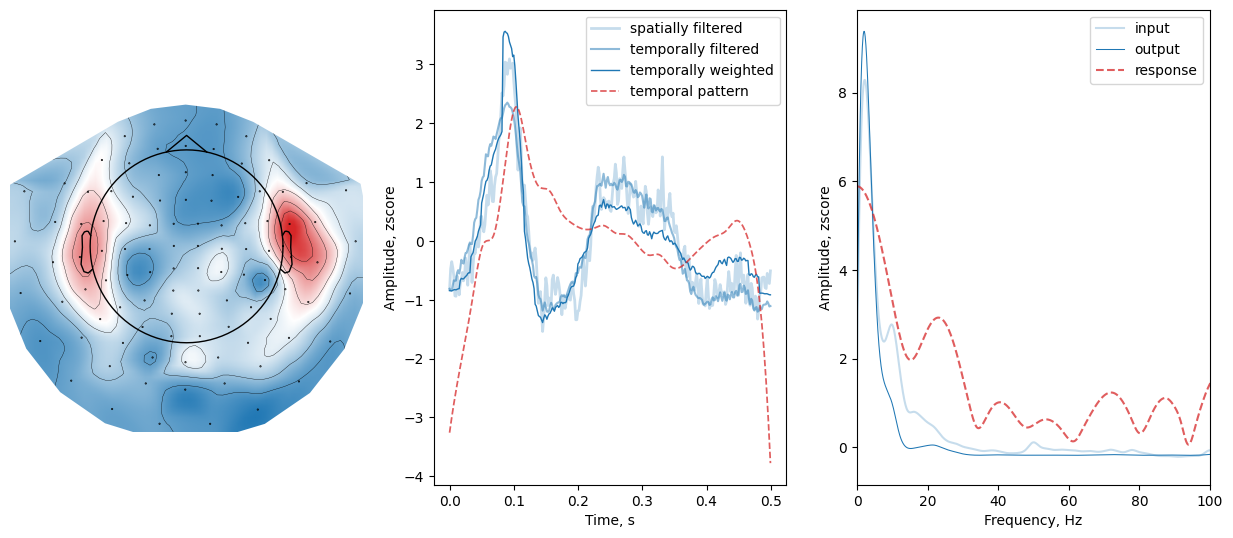

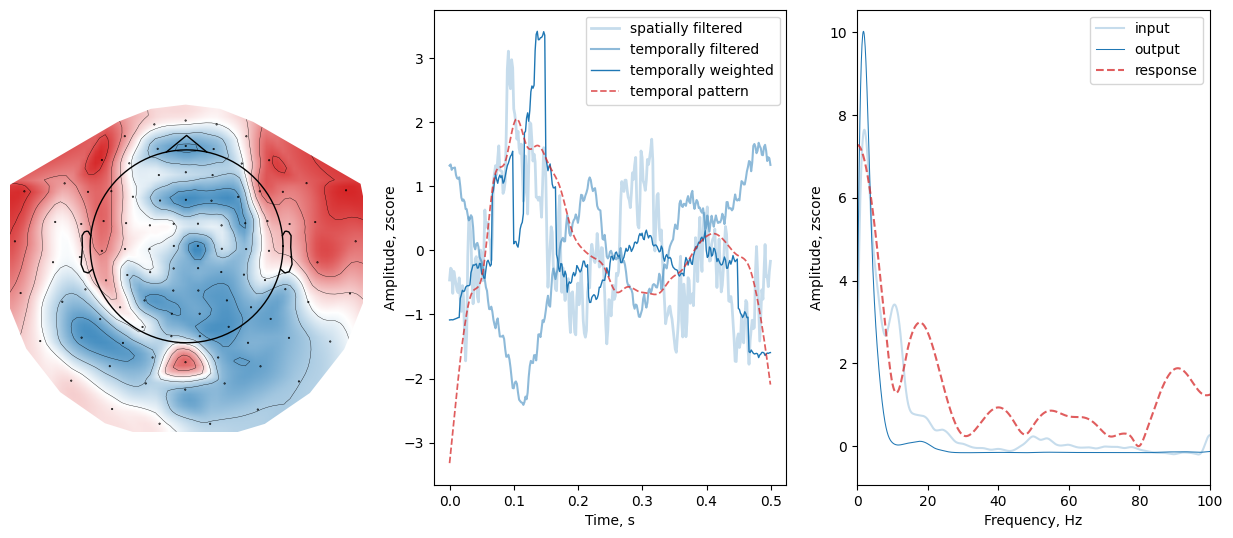

In [85]:
from deepmeg.interpreters import SPIRITInterpreter

interpreter = SPIRITInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [90]:
model_kwargs = {
    'n_channels': 204,
    'n_latent': 8,
    'n_times': X.shape[-1],
    'filter_size': 50,
    'pool_factor': 10,
    'n_outputs': 8
}

In [91]:
TimeCompNet(
    **model_kwargs
)(X)

tensor([[-0.0290,  0.1139, -0.1360,  0.7126,  0.1377, -0.1840,  0.3470,  0.3262]],
       grad_fn=<AddmmBackward0>)

In [92]:
model = TimeCompNet(
    **model_kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                *[f'timesel_list.{i}.0.weight' for i in range(8)],
                *[f'timecomp_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[
                .01, .01,
                *[.001 for _ in range(8)],
                *[.001 for _ in range(8)]
            ]
            # lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [93]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

  0%|          | 0/150 [00:00<?, ?it/s]
'timecomp_list.0.0.weight'


Traceback (most recent call last):
  File "/home/user/Projects/deepmeg/deepmeg/training/trainers.py", line 335, in fit
    train_metrics = self.fit_epoch(train_loader, update_every_n_batches)
  File "/home/user/Projects/deepmeg/deepmeg/training/trainers.py", line 272, in fit_epoch
    batch_metrics = self.fit_batch(train_iterator, update_every_n_batches)
  File "/home/user/Projects/deepmeg/deepmeg/training/trainers.py", line 225, in fit_batch
    new_loss = callback.on_loss_computed(xs, ys_true, ys_pred, loss)
  File "/home/user/Projects/deepmeg/deepmeg/training/callbacks.py", line 415, in on_loss_computed
    loss += lambda_*torch.norm(state_dict[layer_name], 2)
KeyError: 'timecomp_list.0.0.weight'
